In [1]:
# pip installs

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import Transformer

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import AutoTokenizer, AutoModelForMaskedLM

import requests
import os
import json

from torch.utils.data import Dataset, DataLoader, random_split
import random
import math
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define seeds

In [3]:
# define seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Functions to clean the data

In [4]:
# Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)


#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}

# Read a txt file from the author files dictionary
def read_txt_file(file_path):
    """
    This function reads a txt file and returns the text as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def remove_nikud(string):
    """Removes the nikud from the given string."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    return nikud.sub("", string)

def get_nikud(word):
    """Returns the nikud from the given word."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    current_nikud = ''
    nikud_arr = []
    for i in range(len(word)):
        if i == 0:
            continue
        if nikud.match(word[i]):
            current_nikud += word[i]
        else:
            nikud_arr.append(current_nikud)
            current_nikud = ''
    nikud_arr.append(current_nikud)
    return nikud_arr

def add_nikud(word, nikud):
    """Adds the nikud to the given word."""
    new_word = ''
    for i in range(len(word)):
        new_word += word[i] + nikud[i]
    return new_word

def add_nikud_to_text(text, nikud):
    """Adds the nikud to the given text."""
    new_text = ''
    for word in text.split(' '):
        new_text += add_nikud(word, nikud) + ' '
    return new_text

def remove_first_char_if_nikud(word):
    """Removes the first char of the word if it is nikud."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    if nikud.match(word[0]):
        return word[1:]
    return word

def get_words_indices_from_text(text):
    """Returns the indices of the words in the given text."""
    text_words = text.split()
    text_words_lengths = list(map(len, text_words))
    text_words_indices = [(sum(text_words_lengths[:i]), sum(text_words_lengths[:i+1])-1) for i in range(len(text_words_lengths))]
    return text_words_indices

#### Load the data from the csv and remove sentences with more than 100 chars (without spaces) and save as json

##### read the json short data

In [5]:
# read the json file
data_df = pd.read_json('data/full_data_without_puncts.json', orient='records', lines=True, nrows=55000)
print(data_df.shape)

(55000, 6)


In [6]:
# DELETE this block, only for debugging make the data smaller (randomly select 5000 rows)
data_df = data_df.sample(n=5000, random_state=1)
print(data_df.shape)

(5000, 6)


#### Define dictionary label_to_id and id_to_label


In [7]:
label_to_id = {'<no_nikud>': 0}
id_to_label = {0: '<no_nikud>'}
for label_list in tqdm(data_df['nikud']):
    # flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
            id_to_label[len(id_to_label)] = label

print(label_to_id)



100%|██████████| 5000/5000 [00:00<00:00, 86217.40it/s]

{'<no_nikud>': 0, 'ְ': 1, 'ִ': 2, 'ֵ': 3, 'ֶ': 4, 'ֹ': 5, 'ֽ': 6, 'ָ': 7, 'ֲ': 8, 'ַ': 9, 'ֻ': 10, 'ֱ': 11, 'ׇ': 12, 'ֳ': 13, 'ַָ': 14, 'ִַ': 15}


#### count labels for label_weights

100%|██████████| 5000/5000 [00:00<00:00, 73415.81it/s]

{'ְ': 25929, 'ִ': 16984, 'ֵ': 10315, '<no_nikud>': 91941, 'ֶ': 8265, 'ֹ': 9664, 'ֽ': 5095, 'ָ': 23296, 'ֲ': 2770, 'ַ': 18470, 'ֻ': 1059, 'ֱ': 353, 'ׇ': 490, 'ֳ': 49, 'ַָ': 1, 'ִַ': 1}
[('<no_nikud>', 91941), ('ְ', 25929), ('ָ', 23296), ('ַ', 18470), ('ִ', 16984), ('ֵ', 10315), ('ֹ', 9664), ('ֶ', 8265), ('ֽ', 5095), ('ֲ', 2770), ('ֻ', 1059), ('ׇ', 490), ('ֱ', 353), ('ֳ', 49), ('ַָ', 1), ('ִַ', 1)]


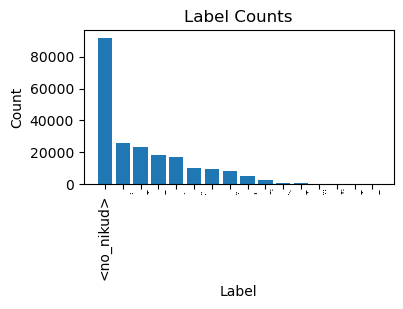

{'<no_nikud>': 0.02152641878669276, 'ְ': 0.06523157208088715, 'ִ': 0.06523157208088715, 'ֵ': 0.06523157208088715, 'ֶ': 0.06523157208088715, 'ֹ': 0.06523157208088715, 'ֽ': 0.06523157208088715, 'ָ': 0.06523157208088715, 'ֲ': 0.06523157208088715, 'ַ': 0.06523157208088715, 'ֻ': 0.06523157208088715, 'ֱ': 0.06523157208088715, 'ׇ': 0.06523157208088715, 'ֳ': 0.06523157208088715, 'ַָ': 0.06523157208088715, 'ִַ': 0.06523157208088715}


In [8]:
# Count the number of each label
label_count = {}
for label_list in tqdm(data_df['nikud']):
    # Flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1

print(label_count)

# Plot counts of each label (sorted)
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_labels)
plt.figure(figsize=(4, 2))
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.bar([x[0] for x in sorted_labels], [x[1] for x in sorted_labels])
plt.show()


def set_no_nikud_weight(weight=0.33):
    label_weights = {}
    for label in label_count:
        if label == "<no_nikud>":
            label_weights[label] = weight
        else:
            label_weights[label] = 1
    sum_weights = sum(label_weights.values())
    for label in label_weights:
        label_weights[label] /= sum_weights
    # sort labels by label_to_id
    label_weights = {k: v for k, v in sorted(label_weights.items(), key=lambda item: label_to_id[item[0]])}
    return label_weights
        
label_weights = set_no_nikud_weight()
print(label_weights)


    

#### download tokenizer and model
(alephbert-base, with vocab of words with len <= 1)

In [9]:
model_path = 'C:\\Users\\baruc\\PycharmProjects\\pythonProject\\Punctuation_Restoration\\AlephBERT-main\\AlephBERT-main\\models\\alephbert-base'
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_path)
alephbert_model = AutoModelForMaskedLM.from_pretrained("onlplab/alephbert-base")

# create DataSet class

In [10]:
# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))

class PunctuationRestorationDataset(Dataset):
    def __init__(self, data_df, tokenizer, label_to_id, max_len):
        self.data = data_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_to_id = label_to_id 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # TODO: need to make sure not to look at fraction of words
        text = self.data.iloc[index]['text_without_nikud']
        nikud = self.data.iloc[index]['nikud']  # list of lists of nikud

        # flatten nikud list
        nikud = [item for sublist in nikud for item in sublist]
        # replace empty strings with <no_nikud> token
        nikud = [label if label != "" else "<no_nikud>" for label in nikud]
        # replace labels with ids
        nikud = [self.label_to_id[label] for label in nikud]

        # check if nikud length is the same as text without spaces length
        if len(text.replace(" ", "")) != len(nikud):
            print("text without spaces length: ", len(text.replace(" ", "")))
            print("nikud length: ", len(nikud))
        
        # get word indices after tokenization
        word_indices = get_words_indices_from_text(text)
        # pad word_indices to be the same length as input_ids
        word_indices = word_indices + [(-1, -1)] * (self.max_len - len(word_indices))
        # convert word_indices to tensor
        word_indices = torch.tensor(word_indices, dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # pad nikud to be the same length as input_ids
        nikud = [0] + nikud + [0]
        nikud = nikud + [len(label_to_id)] * (encoding['input_ids'].shape[1] - len(nikud))
        # convert to tensor
        nikud = torch.tensor(nikud, dtype=torch.long)
        
        return {
            'text': text,
            'nikud': nikud,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word_indices': word_indices
        }


# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))
dataset = PunctuationRestorationDataset(data_df, alephbert_tokenizer, label_to_id, 102)
print("dataset length: ", len(dataset))

# iterate over dataset
for i in range(5):
    sample = dataset[i]
    input_ids = sample['input_ids']
    attention_mask = sample['attention_mask']
    nikud = sample['nikud']
    # check that attention mask has 1s where input_ids does not have padding
    print("attention mask: ", attention_mask)
    print("input_ids: ", input_ids)
    print("nikud: ", nikud)

dataset length:  5000
attention mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
input_ids:  tensor([   2,  181, 1016, 1034, 1016,  188, 1006, 1008,  190, 1007, 1009,  183,
        1039, 1014,  179,  177, 1033, 1010, 1014, 1064,  179, 1008, 1009,  179,
        1047, 1033,  180, 1010, 1008,  187, 1005, 1010,  183, 1075, 1013, 1016,
         187, 1005, 1007,  183, 1075, 1013, 1016,  176, 1008, 1049,  176, 1039,
        1012,  183, 1010, 1044, 1033,  181, 1009, 1033,  188, 1010,  188, 1007,
        1013, 1014,  177, 1038, 1034, 1012,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0

#### split to train,val and test datasets and dataloaders

In [11]:
# split dataset to train, val and test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Full-Sentence Model

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, char_embeddings):
        return self.dropout(char_embeddings + self.pe[:char_embeddings.size(0), :])


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, max_seq_length=102):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, batch_first=True)
        self.output_layer = nn.Linear(d_model, len(label_to_id))
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        # get transformers d_model
        d_model = self.transformer.d_model
        src, tgt = self.embedding(src) * math.sqrt(d_model), self.embedding(tgt) * math.sqrt(d_model)
        src, tgt = self.pos_encoder(src), self.pos_encoder(tgt)

        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return self.output_layer(output)

# MASKING
def generate_square_subsequent_mask(sz):
    mask = torch.ones(sz, sz)
    mask = torch.triu(mask)
    mask = (mask == 1)
    mask = mask.transpose(0, 1)
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))
    return mask


In [15]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(train_loader):
        src = batch["input_ids"].to(device)
        tgt = batch["nikud"].to(device)
        padding_mask = batch["attention_mask"].to(device)
        # conver padding mask to boolean mask
        padding_mask = padding_mask == 0
        # convert padding mask to float
        padding_mask = padding_mask.float()
        
        
        tgt_input = tgt[:, :-1]
        tgt_input_padding_mask = padding_mask[:, :-1]
        tgt_output = tgt[:, 1:]
        tgt_output_padding_mask = padding_mask[:, 1:]
        seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(seq_len).to(device)
        
        optimizer.zero_grad()
        output = model.forward(src, tgt_input, tgt_mask=tgt_mask, src_key_padding_mask=padding_mask, tgt_key_padding_mask=tgt_input_padding_mask)
        output = output.view(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Accuracy
        pred = output.argmax(1)
        tgt_output_padding_mask = tgt_output_padding_mask.reshape(-1)
        pred = pred[tgt_output_padding_mask == 0]
        tgt_output = tgt_output[tgt_output_padding_mask == 0]
        correct_predictions += (pred == tgt_output).sum().item()
        total_predictions += tgt_output.numel()

    accuracy = correct_predictions / total_predictions
    return total_loss / len(train_loader), accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            src = batch["input_ids"].to(device)
            tgt = batch["nikud"].to(device)
            padding_mask = batch["attention_mask"].to(device)
            # conver padding mask to boolean mask
            padding_mask = padding_mask == 0
            # convert padding mask to float
            padding_mask = padding_mask.float()
            
            tgt_input = tgt[:, :-1]
            tgt_input_padding_mask = padding_mask[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_output_padding_mask = padding_mask[:, 1:]
            seq_len = tgt_input.size(1)
            tgt_mask = generate_square_subsequent_mask(seq_len).to(device)
            
            output = model.forward(src, tgt_input, tgt_mask=tgt_mask, src_key_padding_mask=padding_mask, tgt_key_padding_mask=tgt_input_padding_mask)
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
            
            # Accuracy
            pred = output.argmax(1)
            tgt_output_padding_mask = tgt_output_padding_mask.reshape(-1)
            pred = pred[tgt_output_padding_mask == 0]
            tgt_output = tgt_output[tgt_output_padding_mask == 0]
            correct_predictions += (pred == tgt_output).sum().item()
            total_predictions += tgt_output.numel()
            print("pred: ", pred)
            print("tgt_output: ", tgt_output)
    
    accuracy = correct_predictions / total_predictions
    return total_loss / len(val_loader), accuracy


def generate(model, src, max_len):
    model.eval()
    outputs = []
    
    # Loop over each sequence in the batch
    for s in src:
        s = s.unsqueeze(0)  # Add batch dimension
        original_len = s.size(1)  # Track original sequence length
        tgt_init_tok = [1]  # Assuming 1 is the <SOS> token id
        tgt = torch.LongTensor(tgt_init_tok).unsqueeze(0).to(device)
        
        # Pad (or truncate) tgt to match the length of s
        if tgt.size(1) < original_len:
            padding_size = original_len - tgt.size(1)
            padding = torch.zeros(tgt.size(0), padding_size).long().to(device)
            tgt = torch.cat([tgt, padding], dim=1)
        else:
            tgt = tgt[:, :original_len]

        for i in range(max_len):
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            output = model(s, tgt, tgt_mask=tgt_mask)
            next_word = output.argmax(2)[-1, :].item()
            tgt = tgt[:, :-1]  # Remove last token (either padding or previous token)
            tgt = torch.cat([tgt, torch.LongTensor([next_word]).unsqueeze(0).to(device)], dim=1)
            
            if next_word == 2:  # Assuming 2 is the <EOS> token id
                break
        outputs.append(tgt.squeeze(1))  # Remove batch dimension
        
    return torch.stack(outputs, dim=0)  # Convert list of tensors to a single tensor





# hyperparameters
epochs = 5

d_model = 512
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_seq_length = 102
batch_size = 32
lr = 0.0001
seed = 42
vocab_size = alephbert_tokenizer.vocab_size
num_classes = len(label_to_id)

# set seed
torch.manual_seed(seed)
np.random.seed(seed)

# create model
model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length)
model.to(device)
print("number of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

# create optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_weights = set_no_nikud_weight(0.5)
label_weights = label_weights.values()
label_weights = torch.tensor(list(label_weights)).to(device)
print(label_weights)

criterion = nn.CrossEntropyLoss(ignore_index=len(id_to_label), weight=label_weights)

number of parameters:  45071376
tensor([0.0323, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645,
        0.0645, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645, 0.0645],
       device='cuda:0')


In [16]:
# train and validate
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    # print losses and accuracies for each epoch
    print(f'Epoch {epoch + 1}: train loss {train_loss}, val loss {val_loss}')
    print(f'Epoch {epoch + 1}: train acc {train_acc}, val acc {val_acc}')
    # append losses and accuracies (for plotting later)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)




  0%|          | 0/29 [00:00<?, ?it/s]c:\Users\baruc\anaconda3\envs\NLP\lib\site-packages\torch\nn\modules\activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ..\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(
  7%|▋         | 2/29 [00:00<00:01, 15.32it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 7, 4,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([3, 0, 7,  ..., 7, 0, 0], device='cuda:0')


 21%|██        | 6/29 [00:00<00:01, 15.57it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([7, 3, 2,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 3, 0,  ..., 0, 0, 0], device='cuda:0')


 34%|███▍      | 10/29 [00:00<00:01, 15.50it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 7, 0,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 1, 9,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([7, 4, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 3, 0, 0], device='cuda:0')


 48%|████▊     | 14/29 [00:00<00:00, 15.54it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([4, 7, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 3, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 3,  ..., 0, 0, 0], device='cuda:0')


 62%|██████▏   | 18/29 [00:01<00:00, 15.67it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 9, 9,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 7, 0,  ..., 3, 0, 0], device='cuda:0')


 76%|███████▌  | 22/29 [00:01<00:00, 15.96it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([7, 0, 1,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 7, 4,  ..., 0, 0, 0], device='cuda:0')


 83%|████████▎ | 24/29 [00:01<00:00, 15.90it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 9,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 5,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([3, 7, 4,  ..., 0, 0, 0], device='cuda:0')


100%|██████████| 29/29 [00:01<00:00, 16.03it/s]


pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 2, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 1, 7, 0, 7, 7, 0, 2, 6, 0, 5, 0, 3, 6, 0, 2, 1, 3, 2, 0, 0, 0, 5, 1,
        2, 0, 0, 7, 0, 0, 0, 0, 2, 1, 7, 2, 0, 0, 2, 0, 3, 2, 

  7%|▋         | 2/29 [00:00<00:01, 15.79it/s]

pred:  tensor([1, 1, 0,  ..., 0, 7, 5], device='cuda:0')
tgt_output:  tensor([2, 7, 3,  ..., 6, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 1,  ..., 0, 6, 0], device='cuda:0')
tgt_output:  tensor([0, 9, 1,  ..., 5, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 7, 1,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 9, 0,  ..., 0, 0, 0], device='cuda:0')


 21%|██        | 6/29 [00:00<00:01, 15.82it/s]

pred:  tensor([1, 8, 0,  ..., 1, 1, 0], device='cuda:0')
tgt_output:  tensor([9, 0, 0,  ..., 2, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 8, 7,  ..., 0, 0, 5], device='cuda:0')
tgt_output:  tensor([9, 8, 4,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 6, 1], device='cuda:0')
tgt_output:  tensor([0, 2, 4,  ..., 5, 9, 0], device='cuda:0')


 34%|███▍      | 10/29 [00:00<00:01, 15.37it/s]

pred:  tensor([1, 7, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 7, 0,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([1, 4, 0,  ..., 0, 0, 7], device='cuda:0')
tgt_output:  tensor([4, 0, 0,  ..., 3, 1, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 4, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 1,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


 48%|████▊     | 14/29 [00:00<00:00, 15.28it/s]

pred:  tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0')
tgt_output:  tensor([5, 0, 0,  ..., 2, 0, 0], device='cuda:0')
pred:  tensor([0, 1, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 0, 2,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 7, 0, 5], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 0, 0, 0], device='cuda:0')


 69%|██████▉   | 20/29 [00:01<00:00, 15.68it/s]

pred:  tensor([1, 1, 1,  ..., 7, 0, 7], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 3, 6, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 2, 3,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([0, 7, 5,  ..., 0, 1, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 0,  ..., 2, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 7, 0, 0], device='cuda:0')


 76%|███████▌  | 22/29 [00:01<00:00, 15.64it/s]

pred:  tensor([1, 1, 7,  ..., 5, 5, 6], device='cuda:0')
tgt_output:  tensor([0, 1, 2,  ..., 0, 5, 0], device='cuda:0')
pred:  tensor([0, 0, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 9, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 1, 9,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 5,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 5,  ..., 0, 0, 0], device='cuda:0')


 90%|████████▉ | 26/29 [00:01<00:00, 15.63it/s]

pred:  tensor([1, 7, 5,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 8, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([9, 1, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 0,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 0, 0,  ..., 1, 5, 5], device='cuda:0')
tgt_output:  tensor([0, 7, 9,  ..., 0, 0, 0], device='cuda:0')


100%|██████████| 29/29 [00:01<00:00, 15.79it/s]


pred:  tensor([0, 1, 7, 0, 0, 7, 0, 0, 0, 0, 1, 0, 0, 0, 7, 0, 7, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 7, 0, 0, 0, 7, 1, 0, 0, 1, 7, 1, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 7, 1, 7, 0,
        0, 0, 7, 0, 0, 0, 0, 7, 0, 0, 0, 7, 1, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0,
        7, 1, 0, 7, 0, 7, 1, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        7, 0, 1, 7, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 7, 0, 0, 1, 7,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 7, 0, 0, 0, 0, 0, 1, 1, 7, 0, 0, 0, 0, 0, 0, 1, 7, 1, 0, 0, 6, 7, 7,
        0, 0, 0, 1, 0, 4, 0, 1, 0, 7, 0, 6, 7, 1, 1, 7, 4, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 7, 0, 5, 7, 1, 7, 0, 0, 5, 7, 1, 5, 4, 1, 7, 1, 0, 7,
        5, 7, 0, 5], device='cuda:0')
tgt_output:  tensor([ 9,  8,  3,  0,  1,  7,  0,  4,  0,  9,  2,  7,  0,  1,  4, 11,  9,  0,
         4,  3,  0,  0,  4,  0,  9,  1,  3,  0,  5,  6,  9,  0

  7%|▋         | 2/29 [00:00<00:01, 15.35it/s]

pred:  tensor([1, 9, 6,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 2, 1,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 1, 0], device='cuda:0')
tgt_output:  tensor([1, 9, 0,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 6,  ..., 5, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 5, 9,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 0,  ..., 4, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 0, 7,  ..., 0, 0, 0], device='cuda:0')


 21%|██        | 6/29 [00:00<00:01, 12.80it/s]

pred:  tensor([ 1,  1, 11,  4, 11,  0,  1,  7,  5,  5,  0,  0,  0,  0, 11,  0,  0, 11,
         0,  6,  1,  0,  0,  0,  1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  7,  6,
         0,  6,  0,  0,  1,  1,  1,  1,  1,  1,  6,  0,  1,  1,  7,  0,  0,  0,
         1,  7,  4,  0,  0,  0,  0,  6,  0,  6,  4,  0,  4,  7,  0,  0,  1,  0,
         0,  6,  0,  1,  1,  0,  0,  0,  0,  1,  1,  6,  0,  6,  0,  1,  8,  7,
         7,  1,  0,  1,  9,  0,  1,  1,  1,  1,  7,  0,  0,  0,  0,  0,  0,  1,
         0,  6,  0,  0,  7,  1,  7,  1,  7,  0,  0,  0,  0,  0,  1,  7,  1,  7,
         0,  0,  1,  1,  1,  1,  7,  0,  1,  1,  7,  6,  7,  0,  1,  0,  0,  1,
         9,  0,  3, 11,  5, 11,  5,  1,  1,  7,  0,  5,  0,  6,  5,  5,  6,  0,
         0,  1,  1,  7,  0,  7,  0,  0,  0,  1,  7,  0,  0,  0,  0,  0,  7,  1,
         0,  1,  7,  0,  0,  1,  0,  0,  0,  7,  0,  7,  0,  0,  1,  0,  7,  7,
         7,  0,  0,  1,  0,  0,  0,  7,  0,  0,  1,  0,  0,  0,  0,  0,  1,  7,
         0,  0,  0,  7,  0,  0,  

 34%|███▍      | 10/29 [00:00<00:01, 14.08it/s]

pred:  tensor([1, 1, 0,  ..., 0, 1, 0], device='cuda:0')
tgt_output:  tensor([0, 7, 4,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 1, 9,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 7, 9,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 6,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 2, 7,  ..., 7, 0, 0], device='cuda:0')


 48%|████▊     | 14/29 [00:00<00:01, 14.60it/s]

pred:  tensor([1, 9, 0,  ..., 6, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 9, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 1, 7,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 0,  ..., 7, 0, 5], device='cuda:0')
tgt_output:  tensor([1, 7, 5,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 6, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([10,  6,  1,  ...,  7,  0,  0], device='cuda:0')


 62%|██████▏   | 18/29 [00:01<00:00, 14.79it/s]

pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([9, 1, 2,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 0,  ..., 7, 1, 0], device='cuda:0')
tgt_output:  tensor([9, 0, 3,  ..., 2, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([9, 8, 2,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([9, 1, 2,  ..., 0, 0, 0], device='cuda:0')


 76%|███████▌  | 22/29 [00:01<00:00, 14.95it/s]

pred:  tensor([1, 1, 1,  ..., 7, 0, 6], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 5, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 7, 2,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 1,  ..., 3, 0, 0], device='cuda:0')


 83%|████████▎ | 24/29 [00:01<00:00, 14.82it/s]

pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 7, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')


100%|██████████| 29/29 [00:01<00:00, 14.84it/s]


pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 7, 6, 0], device='cuda:0')
tgt_output:  tensor([1, 4, 0,  ..., 2, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 6,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 2, 1,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1, 1, 1, 7, 5, 6, 0, 1, 1, 4, 0, 7, 1, 0, 0, 0, 7, 1, 7, 0, 0, 0,
        0, 0, 4, 0, 0, 0, 1, 0, 7, 0, 0, 1, 7, 0, 7, 0, 0, 1, 7, 0, 0, 1, 7, 6,
        1, 0, 0, 0, 0, 7, 0, 0, 0, 1, 0, 0, 7, 1, 1, 0, 1, 7, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 1, 7, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 9, 6, 1, 0, 1, 1, 7, 0, 1, 1, 1, 6, 1, 7, 0, 0,
        1, 7, 1, 1, 0, 1, 1, 0, 7, 1, 1, 7, 0, 1, 1, 0, 0, 7, 0, 0, 6, 7, 0, 0,
        0, 0, 7, 6, 0, 0], device='cuda:0')
tgt_output:  tensor([ 0,  0, 

  7%|▋         | 2/29 [00:00<00:01, 15.22it/s]

pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 2, 5,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 7, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 1], device='cuda:0')
tgt_output:  tensor([0, 0, 2,  ..., 4, 0, 0], device='cuda:0')


 21%|██        | 6/29 [00:00<00:01, 15.29it/s]

pred:  tensor([0, 0, 2,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 1, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 7, 8, 0], device='cuda:0')
tgt_output:  tensor([7, 7, 0,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 2, 6,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 5, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([ 0,  0,  2,  ..., 11,  0,  0], device='cuda:0')
tgt_output:  tensor([0, 1, 0,  ..., 0, 0, 0], device='cuda:0')


 34%|███▍      | 10/29 [00:00<00:01, 15.34it/s]

pred:  tensor([1, 0, 1,  ..., 0, 5, 5], device='cuda:0')
tgt_output:  tensor([7, 0, 7,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 5, 6, 5], device='cuda:0')
tgt_output:  tensor([0, 0, 3,  ..., 5, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 6, 0, 0], device='cuda:0')
tgt_output:  tensor([2, 0, 1,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([0, 2, 0,  ..., 5, 0, 5], device='cuda:0')
tgt_output:  tensor([1, 2, 1,  ..., 5, 0, 0], device='cuda:0')


 48%|████▊     | 14/29 [00:00<00:00, 15.15it/s]

pred:  tensor([1, 1, 1,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 2, 5,  ..., 8, 6, 5], device='cuda:0')
tgt_output:  tensor([1, 0, 5,  ..., 3, 0, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 3, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 2, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 6,  ..., 0, 5, 0], device='cuda:0')


 62%|██████▏   | 18/29 [00:01<00:00, 14.67it/s]

pred:  tensor([1, 2, 0,  ..., 8, 0, 5], device='cuda:0')
tgt_output:  tensor([1, 4, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 2, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 2, 0,  ..., 8, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 7, 4,  ..., 7, 0, 0], device='cuda:0')


 76%|███████▌  | 22/29 [00:01<00:00, 14.81it/s]

pred:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([ 1, 11,  0,  ...,  0,  0,  0], device='cuda:0')
tgt_output:  tensor([4, 7, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 7,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([0, 7, 0,  ..., 5, 5, 6], device='cuda:0')
tgt_output:  tensor([7, 0, 7,  ..., 0, 5, 0], device='cuda:0')


 90%|████████▉ | 26/29 [00:01<00:00, 15.07it/s]

pred:  tensor([0, 2, 0,  ..., 1, 1, 1], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 2, 5,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 2,  ..., 1, 0, 1], device='cuda:0')
tgt_output:  tensor([0, 1, 9,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 2,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 1, 7,  ..., 0, 0, 0], device='cuda:0')


100%|██████████| 29/29 [00:01<00:00, 15.25it/s]


pred:  tensor([ 1,  1,  7,  ..., 11, 11,  7], device='cuda:0')
tgt_output:  tensor([2, 0, 2,  ..., 4, 1, 0], device='cuda:0')
pred:  tensor([1, 1, 8, 7, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 6, 1,
        1, 1, 1, 2, 0, 1, 6, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 7, 1, 7, 0, 0,
        1, 1, 1, 1, 7, 0, 1, 1, 1, 1, 1, 7, 0, 1, 0, 1, 1, 1, 7, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 7, 1, 7, 0, 0, 7, 0, 0, 0, 0, 7, 1, 0, 0, 0, 7, 1, 7, 0,
        0, 7, 0, 0, 0, 6, 7, 0, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 7, 1, 7, 0, 0, 0, 1, 0, 1, 7, 0, 0, 0, 2, 0, 5, 6, 9, 1,
        7, 1, 7, 7, 5, 5, 1, 5, 0, 0, 5, 0, 5, 7, 0, 7, 1, 0, 7, 7, 1, 6, 1, 7,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 7, 0, 1, 0, 1, 1, 0, 7, 0, 7, 1, 0, 0,
        7, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 7, 0, 7, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 2, 0, 1, 7, 0, 7, 0, 1, 0, 1, 0, 1, 1, 7, 1, 0,

  7%|▋         | 2/29 [00:00<00:01, 14.54it/s]

pred:  tensor([1, 1, 7,  ..., 8, 8, 5], device='cuda:0')
tgt_output:  tensor([2, 0, 0,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 9,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


 21%|██        | 6/29 [00:00<00:01, 14.86it/s]

pred:  tensor([1, 1, 9,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 1, 9,  ..., 0, 5, 0], device='cuda:0')
pred:  tensor([1, 7, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([8, 7, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([ 1,  9, 11,  ...,  0,  0,  0], device='cuda:0')
tgt_output:  tensor([7, 4, 0,  ..., 5, 0, 0], device='cuda:0')


 28%|██▊       | 8/29 [00:00<00:01, 14.77it/s]

pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 1,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 0,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 3, 0,  ..., 7, 0, 0], device='cuda:0')


 41%|████▏     | 12/29 [00:00<00:01, 14.85it/s]

pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 0,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 4, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([ 1,  1,  7,  ..., 11, 11,  5], device='cuda:0')
tgt_output:  tensor([5, 6, 4,  ..., 4, 0, 0], device='cuda:0')
pred:  

 48%|████▊     | 14/29 [00:00<00:01, 14.76it/s]

tensor([1, 8, 6,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([9, 1, 6,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([1, 9, 9,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([ 1,  1,  1,  ...,  7, 11,  0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 4, 0, 0], device='cuda:0')


 62%|██████▏   | 18/29 [00:01<00:00, 14.75it/s]

pred:  tensor([ 1,  1,  1,  ...,  6, 11,  5], device='cuda:0')
tgt_output:  tensor([0, 0, 2,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')


 69%|██████▉   | 20/29 [00:01<00:00, 14.71it/s]

pred:  tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 7, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 9,  ..., 4, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 7,  ..., 7, 0, 1], device='cuda:0')
tgt_output:  tensor([2, 1, 2,  ..., 7, 0, 0], device='cuda:0')


 83%|████████▎ | 24/29 [00:01<00:00, 14.77it/s]

pred:  tensor([1, 1, 1,  ..., 1, 1, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 9, 0, 0], device='cuda:0')
pred:  tensor([1, 9, 3,  ..., 1, 1, 6], device='cuda:0')
tgt_output:  tensor([1, 7, 9,  ..., 0, 5, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 7, 0, 0], device='cuda:0')


 90%|████████▉ | 26/29 [00:01<00:00, 14.65it/s]

pred:  tensor([1, 1, 7,  ..., 0, 0, 1], device='cuda:0')
tgt_output:  tensor([2, 1, 9,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([ 1,  9, 11,  ...,  0,  0,  0], device='cuda:0')
tgt_output:  tensor([1, 4, 0,  ..., 7, 0, 0], device='cuda:0')
pred:  tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
tgt_output:  tensor([0, 0, 0,  ..., 0, 5, 0], device='cuda:0')
pred:  

100%|██████████| 29/29 [00:01<00:00, 14.90it/s]

tensor([1, 1, 9,  ..., 1, 1, 1], device='cuda:0')
tgt_output:  tensor([0, 1, 7,  ..., 0, 0, 0], device='cuda:0')
pred:  tensor([ 1,  1,  1,  9,  6,  1,  0,  1,  0,  1,  1,  3,  9,  6,  1,  0,  1,  0,
         1,  0,  1,  1,  1,  7,  7,  0,  1,  0,  0,  1,  1,  1,  1,  1,  0,  7,
         0,  1,  7,  1,  1,  0,  7,  0,  1,  7,  0,  1,  7,  1,  0,  1,  7,  0,
         0,  1,  0,  1,  1,  1,  7,  0,  1,  1,  1,  0,  0,  0,  0,  1,  9,  0,
         0,  1,  1,  1,  1,  7,  0,  1,  0,  0,  1,  1,  7,  1,  0,  0,  0,  7,
         0,  0,  1,  7,  1,  0,  1,  7,  0,  7,  0,  1,  7,  0,  0,  0,  0,  0,
         0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,
         0,  3,  0,  1,  1,  1,  1,  1, 11,  0,  0,  0,  1,  9,  1,  0,  1],
       device='cuda:0')
tgt_output:  tensor([ 0,  0,  1, 10,  6,  7,  0,  3,  0,  0,  5,  1, 10,  6,  7,  0,  2,  6,
         3,  0,  0,  9,  1,  1,  2,  0,  7,  7,  0,  0,  0,  2,  0,  0,  8,  7,
         0,  1,  9,  0,  2,  1,  7,  0,  1,  7

In [ ]:
# plot losses
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()
# plot accuracies
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()

In [ ]:
predictions = []

for batch in test_loader:
    src = batch["input_ids"].to(device)
    prediction = generate(model, src, max_seq_length)
    predictions.append(prediction)

# Convert predictions to whatever format you need for further processing or analysis


In [ ]:
# def generate_random_data(n):
#     SOS_token = np.array([2])
#     EOS_token = np.array([3])
#     length = 8

#     data = []

#     # 1,1,1,1,1,1 -> 1,1,1,1,1
#     for i in range(n // 3):
#         X = np.concatenate((SOS_token, np.ones(length), EOS_token))
#         y = np.concatenate((SOS_token, np.ones(length), EOS_token))
#         data.append([X, y])

#     # 0,0,0,0 -> 0,0,0,0
#     for i in range(n // 3):
#         X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
#         y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
#         data.append([X, y])

#     # 1,0,1,0 -> 1,0,1,0,1
#     for i in range(n // 3):
#         X = np.zeros(length)
#         start = random.randint(0, 1)

#         X[start::2] = 1

#         y = np.zeros(length)
#         if X[-1] == 0:
#             y[::2] = 1
#         else:
#             y[1::2] = 1

#         X = np.concatenate((SOS_token, X, EOS_token))
#         y = np.concatenate((SOS_token, y, EOS_token))

#         data.append([X, y])

#     np.random.shuffle(data)

#     return data


# def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
#     batches = []
#     for idx in range(0, len(data), batch_size):
#         # We make sure we dont get the last bit if its not batch_size size
#         if idx + batch_size < len(data):
#             # Here you would need to get the max length of the batch,
#             # and normalize the length with the PAD token.
#             if padding:
#                 max_batch_length = 0

#                 # Get longest sentence in batch
#                 for seq in data[idx : idx + batch_size]:
#                     if len(seq) > max_batch_length:
#                         max_batch_length = len(seq)

#                 # Append X padding tokens until it reaches the max length
#                 for seq_idx in range(batch_size):
#                     remaining_length = max_bath_length - len(data[idx + seq_idx])
#                     data[idx + seq_idx] += [padding_token] * remaining_length

#             batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

#     # print(f"{len(batches)} batches of size {batch_size}")

#     return batches


# train_data = generate_random_data(9000)
# val_data = generate_random_data(3000)

# train_dataloader = batchify_data(train_data)
# val_dataloader = batchify_data(val_data)

# for batch in train_dataloader:
#     X, y = batch[:, 0], batch[:, 1]
#     X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

#     # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
#     y_input = y[:,:-1]
#     y_expected = y[:,1:]
#     print("X.shape: ", X.shape)
#     print("X: ", X)
#     print("y_input.shape: ", y_input.shape)
#     print("y_input: ", y_input)
#     print("y_expected.shape: ", y_expected.shape)
#     print("y_expected: ", y_expected)
#     break


In [23]:

class NikudPredictor(nn.Module):
    def __init__(self, vocab_size, pad_idx_src, pad_idx_tgt, no_nikud_id, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(NikudPredictor, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.pad_idx_src = pad_idx_src
        self.pad_idx_tgt = pad_idx_tgt
        self.no_nikud_id = no_nikud_id

    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx_src).unsqueeze(-2)
        return src_mask

    def make_tgt_mask(self, tgt):
        tgt_pad_mask = (tgt != self.pad_idx_tgt).unsqueeze(-2)
        tgt_sub_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1))), diagonal=1)
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        
        embedded_src = self.embedding(src)
        embedded_tgt = self.embedding(tgt)
        
        transformer_out = self.transformer(embedded_src, embedded_tgt, src_mask, tgt_mask)
        output = self.fc_out(transformer_out)
        
        return output

d_model = 512
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
dropout = 0.1
no_nikud_id = 0
pad_idx_src = 0
pad_idx_tgt = len(label_to_id)
# Assuming you have a DataLoader named 'dataloader' that gives you batches of input_ids and target nikud_ids
model = NikudPredictor(vocab_size, pad_idx_src, pad_idx_tgt, no_nikud_id, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx_tgt)

for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        target_nikud_ids = batch["nikud"].to(device)
        optimizer.zero_grad()
        
        # Shift the decoder tokens right (this is a common practice in transformer models)
        input_nikud = torch.cat([torch.full((target_nikud_ids.size(0), 1), no_nikud_id, dtype=torch.long), target_nikud_ids[:, :-1]], dim=1)
        
        outputs = model(input_ids, input_nikud)
        
        # Reshape outputs and target_nikud_ids for loss computation
        outputs = outputs.reshape(-1, outputs.shape[2])
        target_nikud_ids = target_nikud_ids.reshape(-1)
        
        loss = criterion(outputs, target_nikud_ids)
        loss.backward()
        optimizer.step()


  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)